In [1]:
import matplotlib.pyplot as plt
import numpy as np

import engage_geo_client
import engage_visualization

import importlib
importlib.reload(engage_geo_client)
importlib.reload(engage_visualization)

from engage_geo_client import *
from engage_visualization import *

In [2]:
def generate_parameters(base_params):
    parameter_list = []
    for depth in np.arange(2.5, 5, 0.1):
        for wells_prod in range(1, 5):
            for wells_inj in range(1, 5):
                if wells_inj < wells_prod:
                    continue

                # Create a copy of the base parameters and update specific values
                params = base_params.copy()
                params.update(
                    {
                        'Reservoir Depth': depth,
                        'Number of Production Wells': wells_prod,
                        'Number of Injection Wells': wells_inj,
                    }
                )
                parameter_list.append(params)
    return parameter_list

base_params = {
    'Reservoir Model': 3,
    'Drawdown Parameter': 0.00002,
    'Number of Segments': 1,
    'Gradient 1': 70,
    'Maximum Temperature': 400,
    'Production Well Diameter': 8.5,
    'Injection Well Diameter': 8.5,
    'Ramey Production Wellbore Model': 0,
    'Production Wellbore Temperature Drop': 5,
    'Injection Wellbore Temperature Gain': 3,
    'Production Flow Rate per Well': 70,
    'Reservoir Volume Option': 1,
    'Fracture Shape': 1,
    'Fracture Area': 200000,
    'Number of Fractures': 12,
    'Fracture Separation': 80,
    'Injectivity Index': 5,
    'Injection Temperature': 70,
    'Maximum Drawdown': 1,
    'Reservoir Heat Capacity': 1000,
    'Reservoir Density': 3000,
    'Reservoir Thermal Conductivity': 3,
    'Water Loss Fraction': 0.02,
    'End-Use Option': 31,
    'Power Plant Type': 4,
    'Circulation Pump Efficiency': 0.80,
    'Plant Lifetime': 35,
    'Economic Model': 3,
    'Inflated Equity Interest Rate':.08,				
    'Combined Income Tax Rate':.3,		
    'Gross Revenue Tax Rate':0,
    'Print Output to Console': 0 
}

plant = 'CHP'

engage_analysis = EngageAnalysis(plant)

# Generate parameters based on the base parameters
generated_params = generate_parameters(base_params)
engage_analysis.prepare_parameters(generated_params)

# Run iterations and process the data
engage_analysis.run_iterations()

In [4]:
df_final = engage_analysis.get_final_dataframe()

# Sorting and saving to Excel
df_final = df_final.sort_values(
    by=['Depth (m)', 'Number of Prod Wells', 'Number of Inj Wells'], ascending=[True, True, True]
)
df_final.to_csv('results.csv')

# print(df_final)

In [5]:
# Prepare data for plots
cmap = plt.get_cmap('viridis')
unique_prod_wells = df_final['Number of Prod Wells'].unique()
unique_inj_wells = df_final['Number of Inj Wells'].unique()
unique_depth = df_final['Depth (m)'].unique()

# Prepare arrays for scatter plot and linear model
#Surface
heating_capacity = np.array(df_final['Average Heat Production (MWth)'])
electric_capacity = np.array(df_final['Average Electricity Production (MWe)'])

surface_cost = np.array(df_final['Surface Plant Cost ($M)'])
surface_o_m_cost = np.array(df_final['Surface maintenance costs ($MUSD/yr)'])

#Reservoir
thermal_capacity = np.array(df_final['Average Reservoir Heat Extraction (MWth)'])
reservoir_cost = np.array(df_final['Drilling and completion cost ($MUSD)']) 
reservoir_o_m_cost = np.array(df_final['Wellfield maintenance costs ($MUSD/yr)']) + np.array(
    df_final['Make-Up Water O&M Cost ($MUSD/year)']
)


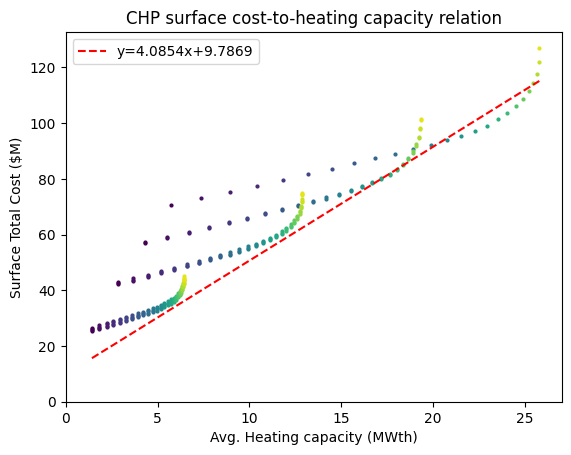

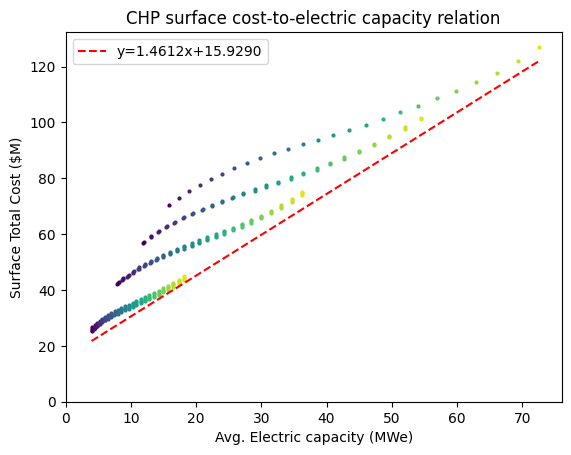

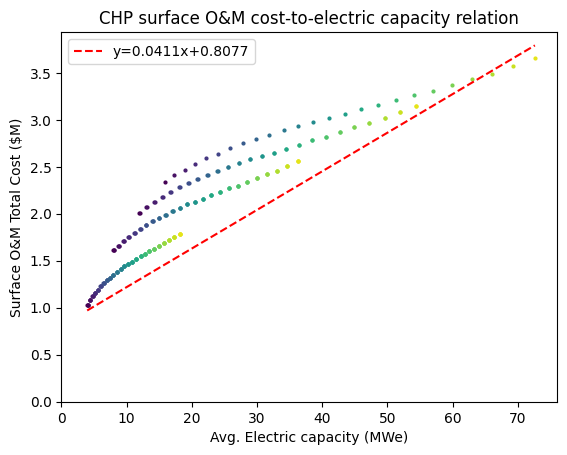

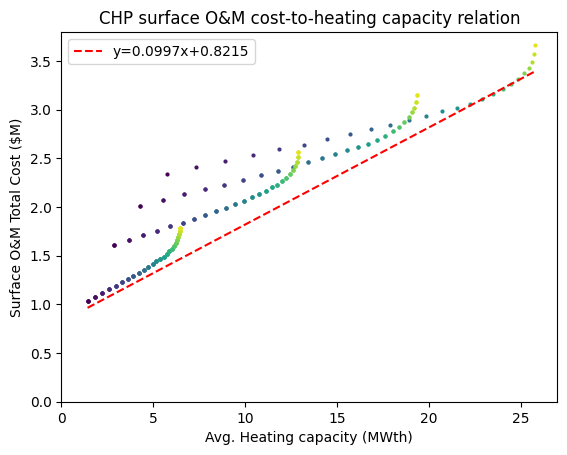

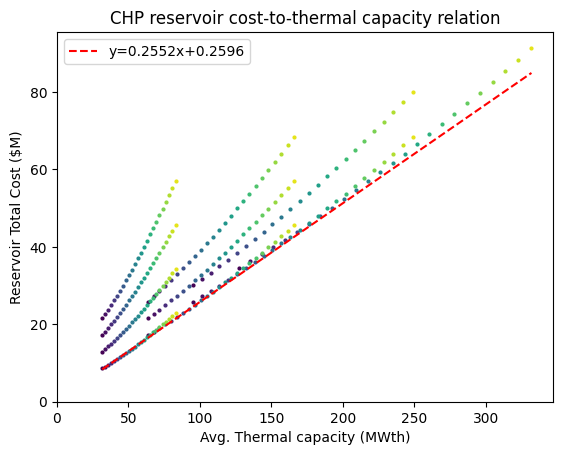

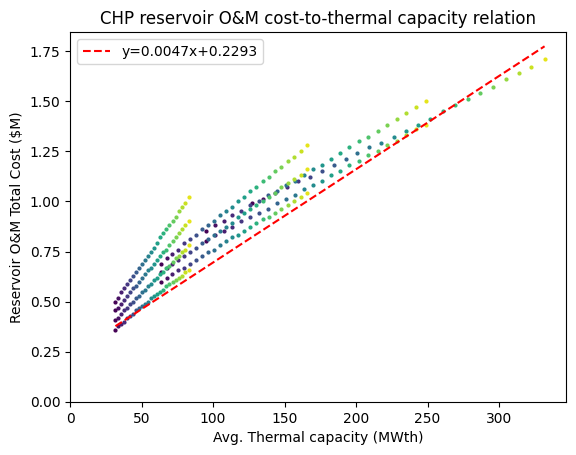

In [6]:
# Fit linear models for each relationship
# Surface
a1, b1, x1_line, lower_b1_line, label_b1 = fit_linear_model(heating_capacity, surface_cost, 10,0.1,-2)         # heating cap vs surface cost
a2, b2, x2_line, lower_b2_line, label_b2 = fit_linear_model(electric_capacity, surface_cost, 5,-0.05,-2)         # electric cap vs surface cost
a3, b3, x3_line, lower_b3_line, label_b3 = fit_linear_model(electric_capacity, surface_o_m_cost, 1,0,0)     # electric cap vs surface O&M cost
a4, b4, x4_line, lower_b4_line, label_b4 = fit_linear_model(heating_capacity, surface_o_m_cost, 1,0,0)      # heating cap vs surface O&M cost

# Reservoir
a5, b5, x5_line, lower_b5_line, label_b5 = fit_linear_model(thermal_capacity, reservoir_cost, 1,0.1,0)        # thermal cap vs reservoir cost
a6, b6, x6_line, lower_b6_line, label_b6 = fit_linear_model(thermal_capacity, reservoir_o_m_cost, 5,0.1,0)    # thermal cap vs reservoir O&M cost

# Create scatter plots for each relationship
# Heating Capacity vs Surface Cost
create_scatter_plot(
    heating_capacity,
    surface_cost,
    x1_line,
    lower_b1_line,
    label_b1,
    f'{plant} surface cost-to-heating capacity relation',
    'Avg. Heating capacity (MWth)',
    'Surface Total Cost ($M)',
    cmap,
    unique_prod_wells,
    unique_inj_wells,
    unique_depth,
    df_final,
)

# Electric Capacity vs Surface Cost
create_scatter_plot(
    electric_capacity,
    surface_cost,
    x2_line,
    lower_b2_line,
    label_b2,
    f'{plant} surface cost-to-electric capacity relation',
    'Avg. Electric capacity (MWe)',
    'Surface Total Cost ($M)',
    cmap,
    unique_prod_wells,
    unique_inj_wells,
    unique_depth,
    df_final,
)

# Electric Capacity vs Surface O&M Cost
create_scatter_plot(
    electric_capacity,
    surface_o_m_cost,
    x3_line,
    lower_b3_line,
    label_b3,
    f'{plant} surface O&M cost-to-electric capacity relation',
    'Avg. Electric capacity (MWe)',
    'Surface O&M Total Cost ($M)',
    cmap,
    unique_prod_wells,
    unique_inj_wells,
    unique_depth,
    df_final,
)

# Heating Capacity vs Surface O&M Cost
create_scatter_plot(
    heating_capacity,
    surface_o_m_cost,
    x4_line,
    lower_b4_line,
    label_b4,
    f'{plant} surface O&M cost-to-heating capacity relation',
    'Avg. Heating capacity (MWth)',
    'Surface O&M Total Cost ($M)',
    cmap,
    unique_prod_wells,
    unique_inj_wells,
    unique_depth,
    df_final,
)

# Thermal Capacity vs Reservoir Cost
create_scatter_plot(
    thermal_capacity,
    reservoir_cost,
    x5_line,
    lower_b5_line,
    label_b5,
    f'{plant} reservoir cost-to-thermal capacity relation',
    'Avg. Thermal capacity (MWth)',
    'Reservoir Total Cost ($M)',
    cmap,
    unique_prod_wells,
    unique_inj_wells,
    unique_depth,
    df_final,
)

# Thermal Capacity vs Reservoir O&M Cost
create_scatter_plot(
    thermal_capacity,
    reservoir_o_m_cost,
    x6_line,
    lower_b6_line,
    label_b6,
    f'{plant} reservoir O&M cost-to-thermal capacity relation',
    'Avg. Thermal capacity (MWth)',
    'Reservoir O&M Total Cost ($M)',
    cmap,
    unique_prod_wells,
    unique_inj_wells,
    unique_depth,
    df_final,
)

# Save all plots to a PDF
fig_nums = plt.get_fignums()

save_image('results.pdf', fig_nums)


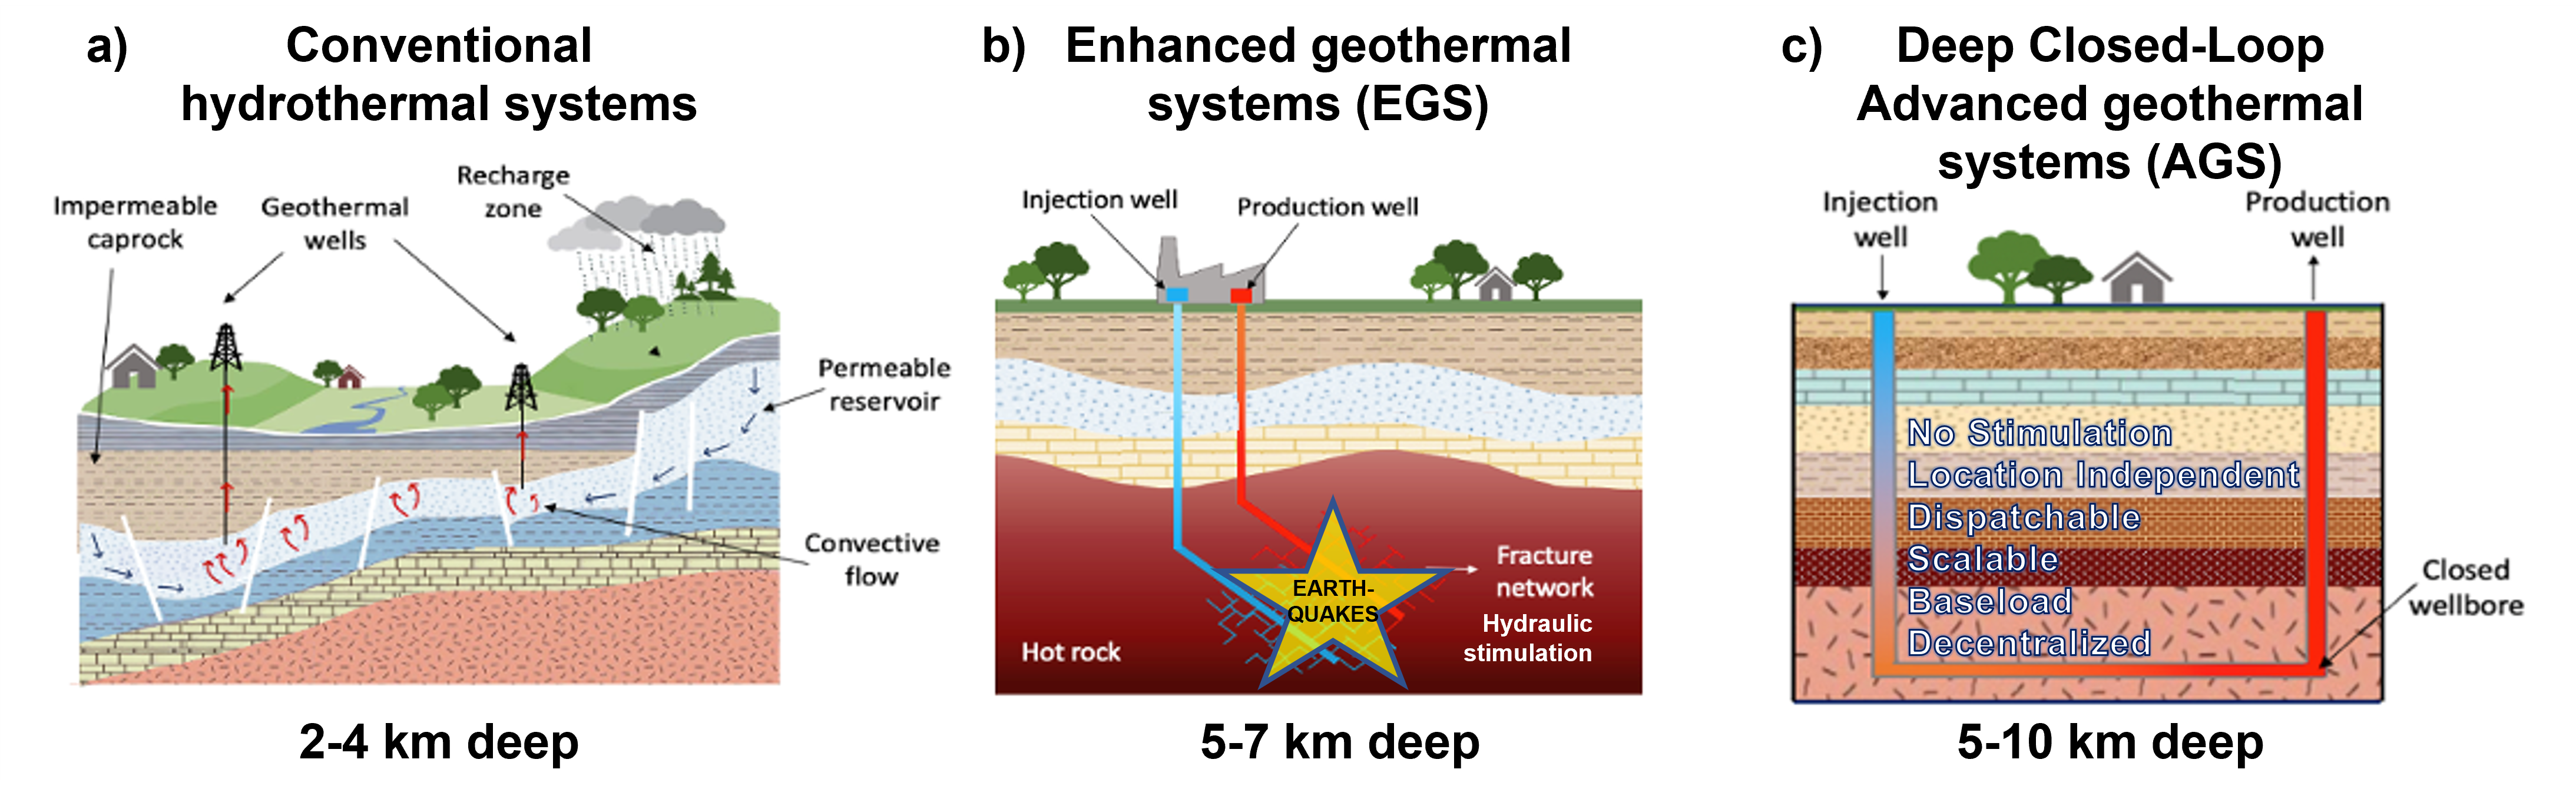